In [1]:
import os.path
import tarfile
import urllib

from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# IMPORTANT!
We tested this spike with three different datasets.
Asign to `selected_dataset` the number of the chosen dataset.

1 = TCGA DATASET(default) contains gene expression values from a manuscript authored by The Cancer Genome Atlas (TCGA) Pan-Cancer analysis project investigators.

2 = Synthetic 2-d DATASET

3 = CUSTOM DATASET which could be modified changing its parameters

In [2]:
selected_dataset = 1

## TCGA DATASET

In [3]:
# Check if dataset was already downloaded.
if not(os.path.isfile("TCGA-PANCAN-HiSeq-801x20531/data.csv")):
    uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
    archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

    # Build the url
    full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

    # Download the file
    r = urllib.request.urlretrieve(full_download_url, archive_name)

    # Extract the data from the archive
    tar = tarfile.open(archive_name, "r:gz")
    tar.extractall()
    tar.close()

In [4]:
if (selected_dataset == 1):
    datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
    labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

    # Create numpy array from data csv
    data = np.genfromtxt(
        datafile,
        delimiter=",",
        usecols=range(1, 20532),
        skip_header=1
    )

    # Create numpy array from labels csv
    true_label_names = np.genfromtxt(
        labels_file,
        delimiter=",",
        usecols=(1,),
        skip_header=1,
        dtype="str"
    )

## Synthetic 2-d DATASET

In [5]:
if (selected_dataset == 2):
    datafile = "./generated-dataset/s1.csv"
    labels_file = "./generated-dataset/labels.csv"

    # Create numpy array from data csv
    data = np.genfromtxt(
        datafile,
        delimiter=",",
        usecols=range(1, 3)
    )

    # Create numpy array from labels csv
    true_label_names = np.genfromtxt(
        labels_file,
        delimiter=",",
        usecols=(0,),
        dtype="str"
    )

## CUSTOM DATASET

In [6]:
if (selected_dataset == 3):
    data, true_label_names = make_blobs(
        n_samples=5000,     # number of dataset samples
        centers=3,         # number of centers in which the samples will be grouped
        cluster_std=1.7,   # proximity of samples to their center
        random_state=342
    )

# K-Means
### Prepare Labels

Labels are useful to let us know to which cluster each point corresponds when displaying results.

In [7]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

In [8]:
print(label_encoder.classes_)

['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']


### Get Optimum K
Since we have non-labeled data, we need to determine the amount `K` of clusters to use. The following three cells calculate the optimum number of clusters using the elbow method.

In [9]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# for higher number of clusters is required a higher k_max
# k_max must be at least three times bigger than the expected k
k_max = 20  
# A list holds the SSE values for each k
sse = []
for k in range(1, k_max):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

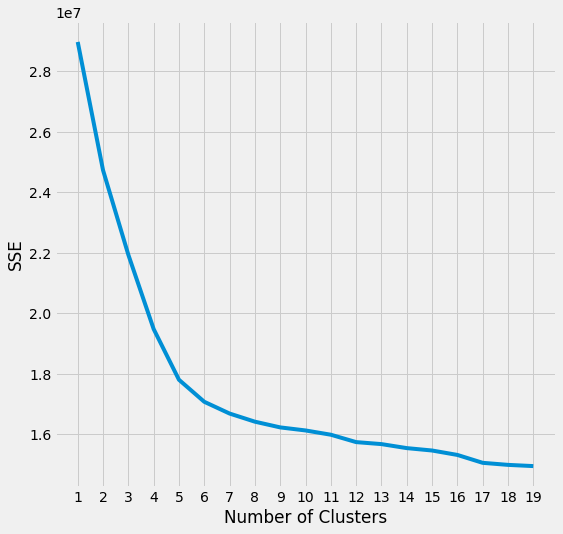

In [10]:
# plot the SSE values
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
plt.plot(range(1, k_max), sse)
plt.xticks(range(1, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [11]:
kl = KneeLocator(
    range(1, k_max), sse, curve="convex", direction="decreasing"
)

k = kl.elbow
kl.elbow

5

### Prepare the SKLearn Pipeline

The SciKit Learn Pipeline class can be chained to form a larger pipeline. The following cells build an end-to-end k-means clustering pipeline by passing the "preprocessor" and "clusterer" pipelines to the main Pipeline called `pipe`

In [12]:
# Initialize the preprocessor, which preprocess the dataset to give it the optimal format
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=1)),
    ]
)

In [13]:
# Initialize the clusterer, where is configured the KMeans clusterer
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=k,
               init="k-means++",
               n_init=10,
               max_iter=300,
               random_state=325,
           ),
       ),
   ]
)

In [14]:
# Initialize the complete pipeline. First the data will be processed and then clustering will run.
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

### Fit model

In [15]:
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=1))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(n_clusters=5, random_state=325))]))])

### Evaluate performance with Silhouette coefficient:
A silhouette coefficient of 0 indicates that clusters are significantly overlapping one another, and a silhouette coefficient of 1 indicates clusters are well-separated.

In [16]:
preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.5118775537364763

In [17]:
preprocessed_data.shape

(801, 2)

### Calculate ARI
An ARI score of 0 indicates that cluster labels are randomly assigned, and an ARI score of 1 means that the true labels and predicted labels form identical clusters.

In [18]:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

### Plot Results

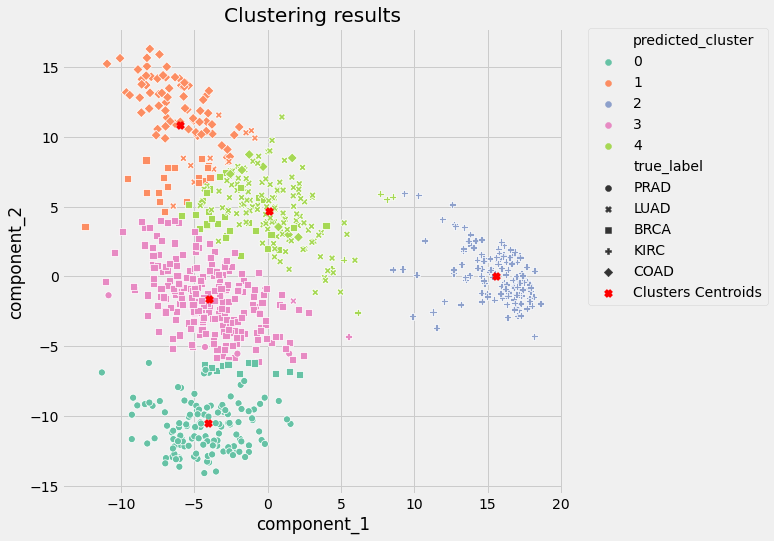

In [19]:
centers = pipe["clusterer"]["kmeans"].cluster_centers_  # centroids
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results"
)
plt.scatter(centers[:, 0], centers[:, 1], marker="x", color='r', label='Clusters Centroids')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()